# Juggling RL project

## Install dependencies

It is also necessary to have ffmpeg software installed, in particular its bin folder in your path : <br>

On Windows : tuto - https://www.wikihow.com/Install-FFmpeg-on-Windows <br>
download - https://www.gyan.dev/ffmpeg/builds/


In [1]:
#!pip install gymnasium
#!pip install keras-rl
#!pip install mediapy
#!pip install mujoco

## Import Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mujoco
import mediapy as media
import gymnasium as gym
from gymnasium import spaces

## Import model

""

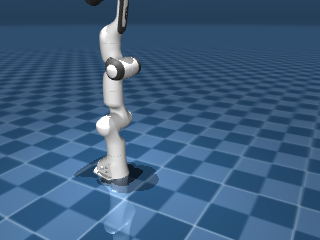

In [2]:
# Make model and data -- https://mujoco.readthedocs.io/en/stable/python.html
model = mujoco.MjModel.from_xml_path("./robot/scene.xml") #
data = mujoco.MjData(model)

# Make renderer, render and show the pixels
renderer = mujoco.Renderer(model)
mujoco.mj_forward(model, data)
renderer.update_scene(data)

media.show_image(renderer.render())

In [3]:
duration = 4  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.
data.ctrl[2]=-1.9
while data.time < duration: #data.time in second (float)
  if int(data.time*1000) % 1000 == 0: print(data.time)
  mujoco.mj_step(model, data)
  if len(frames) < data.time * framerate:
    renderer.update_scene(data)
    pixels = renderer.render().copy()
    frames.append(pixels)
media.show_video(frames, fps=framerate)

0.0
1.0000000000000007
2.0000000000000013


In [58]:
# Format of a trajectory (dur_cycle, ((t1, x1, y1, z1), ..., (tn, xn, yn, zn)))
# Format of a command (dur_cycle, ((t1, act2-1, act3-1), ..., (tn, act2-n, act3-n)))
# command[0] = 0 if not a cycle
# command[0] > 0 if it is a cycle (then dur_cycle > tn)

def trajectory_to_command(trajectory): # Error if out of range
    pass

def update_arm(command, current_time, command_step):
    #print(round(current_time, 3))
    if (int(round(current_time * 1000)) % int(round(command[0]*1000)) == 
        int(round(command[1][command_step][0]*1000))):
        data.ctrl[1] = command[1][command_step][1]
        data.ctrl[2] = command[1][command_step][2]
        command_step = (command_step + 1) % len(command[1])
        print(command_step)
    #print("in function", command_step)
    return command_step

In [59]:
duration = 7  # (seconds)
framerate = 60  # (Hz)

# Simulate and display video.
def simulation_video(command):
  frames = []
  mujoco.mj_resetData(model, data)  # Reset state and time.
  command_step = 0
  while data.time < duration: #data.time in second (float)
    #if abs(round(data.time) - data.time) < 0.005: print(data.time)
    if int(round(data.time * 1000)) % 1000 == 0: print(f"Computed {int(data.time)} out of {duration} seconds")
    command_step = update_arm(command, data.time, command_step)
    mujoco.mj_step(model, data)
    if len(frames) < data.time * framerate:
      renderer.update_scene(data)
      pixels = renderer.render().copy()
      frames.append(pixels)
    #print(command_step)
    
      
  return frames

In [63]:
command = (4, ((0, -0.476, -2.14), (1, 0.176, -2), 
               (2, 0.688, -0.715), (3, 0.2, -1.11)))
media.show_video(simulation_video(command), fps=framerate)

Computed 0 out of 7 seconds
1
Computed 1 out of 7 seconds
2
Computed 2 out of 7 seconds
3
Computed 2 out of 7 seconds
0
Computed 3 out of 7 seconds
1
Computed 4 out of 7 seconds
2
Computed 5 out of 7 seconds
3
Computed 6 out of 7 seconds
0


## Create the gym environment

We created our environment in envs/Juggling_Env.py.

In [1]:
import gymnasium as gym
import custom_gym

env = gym.make('Juggler',render_mode="rgb_array")

/Users/joekhawand/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:190: UserWarning: WARN: Future gymnasium versions will require that `Env.reset` can be passed a `seed` instead of using `Env.seed` for resetting the environment random number generator.
  logger.warn(
/Users/joekhawand/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:203: UserWarning: WARN: Future gymnasium versions will require that `Env.reset` can be passed `options` to allow the environment initialisation to be passed additional information.
  logger.warn(
/Users/joekhawand/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:211: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'NoneType'>`
  logger.warn(
/Users/joekhawand/miniforge3/lib/python3.10/site-packages/gymnasium/

""

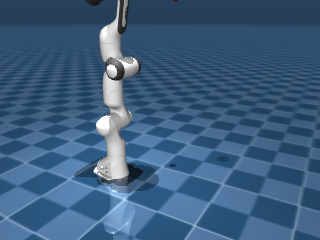

/Users/joekhawand/miniforge3/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:293: UserWarning: WARN: RGB-array rendering should return a numpy array, got <class 'NoneType'>
  logger.warn(


In [2]:
env.reset()
env.step([0,0,-1.9])
env.render()

""

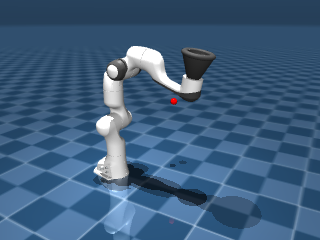

In [35]:
env.step([0,0,-1.9])
env.render()

## Create a deep learning model

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
def build_model(states, actions):
    model = Sequential()    
    model.add(Dense(24, activation='relu', input_shape=states))
    model.add(Dense(24, activation='relu'))
    model.add(Dense(actions, activation='linear'))
    return model

In [ ]:
del model

In [ ]:
model = build_model(states, actions)

In [ ]:
model.summary()

## Keras RL agent

In [ ]:
from rl.agents import DQNAgent
from rl.policy import BoltzmannQPolicy
from rl.memory import SequentialMemory

In [ ]:
def build_agent(model, actions):
    policy = BoltzmannQPolicy()
    memory = SequentialMemory(limit=50000, window_length=1)
    dqn = DQNAgent(model=model, memory=memory, policy=policy, 
                  nb_actions=actions, nb_steps_warmup=10, target_model_update=1e-2)
    return dqn

In [ ]:
dqn = build_agent(model, actions)
dqn.compile(Adam(lr=1e-3), metrics=['mae'])
dqn.fit(env, nb_steps=50000, visualize=False, verbose=1)